In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Let's get every last CSV file stored in a nice, tidy dictionary.
munging_folders = ["NANdrop", "Imputation"]
city_names = ["Mumbai", "Kolkata", "Hyderabad", "Delhi", "Chennai", "Bangalore"]
master_dict = {}
for folder in munging_folders:
  master_dict[folder] = {}
  for city in city_names:
    master_dict[folder][city] = pd.read_csv('/content/drive/MyDrive/SENG474Project/DataMunging/' + folder + '/' + city + 'DataMunging.csv').drop(["Unnamed: 0"], axis = 1)
    # Note that a superfluous artifact column is dropped in the above line

In [ ]:
# Let's take a look at one of those DataFrames to make sure everything is working.
master_dict['Imputation']['Hyderabad']

,Price,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,ATM,ClubHouse,School,24X7Security,PowerBackup,CarParking,StaffQuarter,Cafeteria,MultipurposeRoom,Hospital,WashingMachine,Gasconnection,AC,Wifi,KidsPlayArea,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Latitude,Longitude
0,0.030479,0.094382,0.142857,0.0,0.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.0000,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.087768,0.990652
1,0.165644,0.336854,0.428571,0.0,0.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.0000,1.000000,0.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.085681,0.990633
2,0.028160,0.091910,0.142857,0.0,0.00000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.083789,0.990657
3,0.022939,0.089326,0.285714,1.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.087542,0.991470
4,0.022571,0.072472,0.142857,0.0,0.00000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.087206,0.990785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,0.055215,0.107865,0.142857,1.0,0.11627,0.454807,0.423583,0.32991,0.268694,0.316763,0.290058,0.0682,0.391947,0.26212,0.125719,0.425637,0.041906,0.420296,0.657354,0.451109,0.098603,0.117091,0.239934,0.041085,0.020542,0.089565,0.039852,0.026705,0.469597,0.69885,0.062038,0.317584,0.043961,0.030813,0.021775,0.035333,0.04355,0.042317,0.025472,0.084835,0.991762
2247,0.147239,0.091461,0.142857,1.0,0.11627,0.454807,0.423583,0.32991,0.268694,0.316763,0.290058,0.0682,0.391947,0.26212,0.125719,0.425637,0.041906,0.420296,0.657354,0.451109,0.098603,0.117091,0.239934,0.041085,0.020542,0.089565,0.039852,0.026705,0.469597,0.69885,0.062038,0.317584,0.043961,0.030813,0.021775,0.035333,0.04355,0.042317,0.025472,0.083789,0.990657
2248,0.069325,0.238764,0.285714,1.0,0.11627,0.454807,0.423583,0.32991,0.268694,0.316763,0.290058,0.0682,0.391947,0.26212,0.125719,0.425637,0.041906,0.420296,0.657354,0.451109,0.098603,0.117091,0.239934,0.041085,0.020542,0.089565,0.039852,0.026705,0.469597,0.69885,0.062038,0.317584,0.043961,0.030813,0.021775,0.035333,0.04355,0.042317,0.025472,0.085289,0.990693
2249,0.053988,0.174157,0.285714,0.0,0.11627,0.454807,0.423583,0.32991,0.268694,0.316763,0.290058,0.0682,0.391947,0.26212,0.125719,0.425637,0.041906,0.420296,0.657354,0.451109,0.098603,0.117091,0.239934,0.041085,0.020542,0.089565,0.039852,0.026705,0.469597,0.69885,0.062038,0.317584,0.043961,0.030813,0.021775,0.035333,0.04355,0.042317,0.025472,0.085681,0.990633


Professor Numanagic told us, in response to our progress report, the following words: "Make sure to implement a simpler model (say, lin. regression or NN) as a baseline. I’d like to see concrete numbers as why trees are better than NNs."

Accordingly, we here train a set of basic densely-connected neural networks to do the same task as our AdaBoostRegressors. Like our AdaBoostRegressors, these neural networks operate on both permutations of the input data: the version where all rows containing NaNs have been dropped, and the version where NaNs have been replaced via simple imputation.

In [ ]:
# Now let's get each DataFrame translated into two NumPy arrays: features and labels.
for folder in master_dict.keys():
  for city in master_dict[folder].keys():
    tmpnp = master_dict[folder][city].to_numpy()
    master_dict[folder][city] = {
        'features': np.delete(arr=tmpnp, obj=0, axis=1),
        'labels': tmpnp[:, 0]
    }

In [ ]:
# Let's make sure that the above operation worked correctly.
master_dict['Imputation']['Hyderabad']['labels']

array([0.03047853, 0.16564417, 0.02815951, ..., 0.06932515, 0.05398773,
       0.05153374])

# Basic Dense Neural Network

In [ ]:
# Now let's set up our basic model.
# Parameters are all set to be either the most standard-issue components or the components that make it easiest to compare this neural network with the AdaboostRegressor.
from sklearn.neural_network import MLPRegressor

# Note: anti-overfitting is built into MLPRegressor by default; the "tol" (tolerance) parameter, with a default value of 1e-4, stops training if progress slows
regressor_nn = MLPRegressor(
    hidden_layer_sizes=(100, 100), # Two 100-node hidden layers for a basic but capable network
    activation='relu', # Again, we choose the most basic options possible for comparison's sake
    solver='sgd', # Again, we choose the most basic options possible for comparison's sake
    tol=1e-4, # The default tolerance value. Declaring explicitly for clarity's sake; this prevents overfitting by stopping progress if it slows beyond this
    momentum=0, # Again, we choose the most basic options possible for comparison's sake
    early_stopping=True, # Anti-overfit protection. Necessary to train this network through the optimum number of epochs for suitable comparison.
    max_iter=500 # Five times the default; this is necessary to allow this network to come closer to convergence. It takes many iterations because of the single point of feedback.
    # Not even 500 iterations is anywhere near the number required for convergence; in preliminary testing, this architecture sometimes failed to converge even after 5000 iterations.
    )

# Now, let's actually evaluate the model. We're using 10-fold cross-validation here, 10 being the commonly recommended number of folds used in k-fold cross-validation.
kfold = sk.model_selection.KFold(n_splits=10)

# Run neural-network-based regression on every city's data in both data-preprocessing formats
for data_type in ['NANdrop', 'Imputation']:
  for city in master_dict[data_type].keys():
    master_dict[data_type][city]['nn_cv_scores'] = sk.model_selection.cross_val_score(estimator=regressor_nn, X=master_dict[data_type][city]['features'], y=master_dict[data_type][city]['labels'], cv=kfold)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# AdaBoostRegressor

Here's what cross_val_score's output means:
  * cross_val_score takes an average over cross-validation folds
  * The score computed at each CV iteration is the score method of the estimator. So what's the score method of each of these estimators?
    * Each score method "returns the coefficient of determination R^2 of the prediction". The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor.score
    * so, based on this incomplete table, the ABR performs wayyyyy better

We're aiming for full comparison of the four strategies, remember.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

regressor_adaboost = AdaBoostRegressor(
    n_estimators=100, # Just like how two hidden layers instead of the default one were used in the neural network setup, n_estimators has been set to double the default
    loss='square', # For comparability with the neural network, which also uses squared error
    random_state=1337 # For reproducibility
    )

kfold = sk.model_selection.KFold(n_splits=10) # This line is redundant, but is included anyway so this cell works whether or not the previous, identical call was ever made

for data_type in ['NANdrop', 'Imputation']:
  for city in master_dict[data_type].keys():
    master_dict[data_type][city]['ada_cv_scores'] = sk.model_selection.cross_val_score(estimator=regressor_adaboost, X=master_dict[data_type][city]['features'], y=master_dict[data_type][city]['labels'], cv=kfold)

In [ ]:
master_dict['NANdrop']['Hyderabad']['ada_cv_scores']

array([-1.26751154,  0.60250421,  0.06429367,  0.37926247,  0.58023642,
        0.50353633,  0.71696988,  0.6846705 , -0.04786235,  0.4986757 ])

# Results Graphing

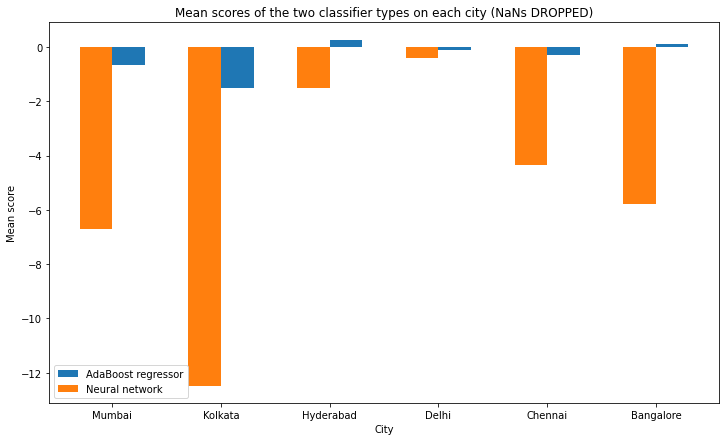

In [ ]:
# each pair of bars is a city in city_names
ticksrange = np.arange(len(city_names))

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(7)

plt.bar(ticksrange+0.15, [np.mean(master_dict['NANdrop'][city]['ada_cv_scores']) for city in city_names], 0.3, label = "AdaBoost regressor")
plt.bar(ticksrange-0.15, [np.mean(master_dict['NANdrop'][city]['nn_cv_scores']) for city in city_names], 0.3, label = "Neural network")
# NOTE: gotta plot the cities in city_names order, so traverse the dictionary that way.

plt.title("Mean scores of the two classifier types on each city (NaNs DROPPED)")
plt.xlabel("City")
plt.ylabel("Mean score")
plt.xticks(ticksrange, city_names)
plt.legend()

plt.show()

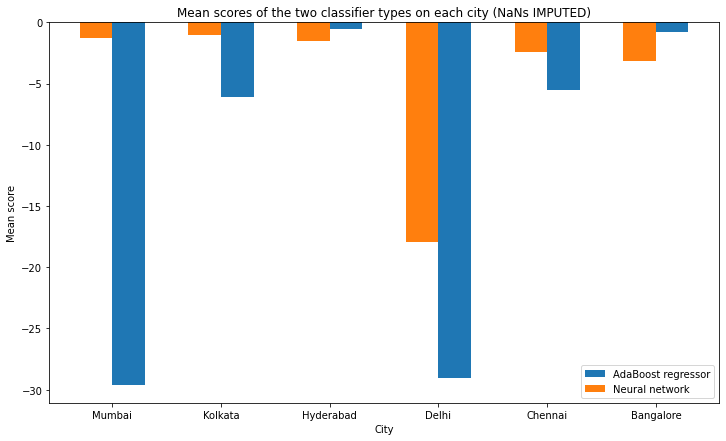

In [ ]:
# each pair of bars is a city in city_names
ticksrange = np.arange(len(city_names))

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(7)

plt.bar(ticksrange+0.15, [np.mean(master_dict['Imputation'][city]['ada_cv_scores']) for city in city_names], 0.3, label = "AdaBoost regressor")
plt.bar(ticksrange-0.15, [np.mean(master_dict['Imputation'][city]['nn_cv_scores']) for city in city_names], 0.3, label = "Neural network")
# NOTE: gotta plot the cities in city_names order, so traverse the dictionary that way.

plt.title("Mean scores of the two classifier types on each city (NaNs IMPUTED)")
plt.xlabel("City")
plt.ylabel("Mean score")
plt.xticks(ticksrange, city_names)
plt.legend()

plt.show()